In [1]:
import os
import datetime
from datetime import timedelta
import quandl
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

import warnings
import functools
import wrds
import sys
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
db = wrds.Connection()


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
earnings_dates_for_tickers = pd.read_csv("earnings_dates_for_tickers.csv")

In [4]:
csv_file_path = "secids.csv"

# Reading the CSV file into a NumPy array
secids = np.genfromtxt(csv_file_path, delimiter=',')
secids

array([101149., 205456., 210354., ..., 211262., 207854., 105959.])

In [5]:
options_dict = {} 
for year in range(2017, 2024):
    print(year)
    table_name = f"optionm.opprcd{year}"  # Generate table name dynamically
    query = f"""
    SELECT
        date, secid, symbol, cp_flag, expiry_indicator, volume, strike_price, exdate, open_interest, impl_volatility, best_bid, best_offer, delta, gamma, vega, theta
    FROM 
        {table_name} a 
    WHERE
        a.secid IN ({','.join(map(str, secids))}) AND
        a.volume > 0 AND
        a.exdate - a.date <= 7
    """
    options_dict[year] = db.raw_sql(query, date_cols=['date'])

2017
2018
2019
2020
2021
2022
2023


In [6]:
for year in range(2017, 2024):
    # Get the DataFrame for the current year
    options = options_dict[year]
    
    # Split the 'symbol' column and extract the first substring as 'ticker'
    options['ticker'] = options['symbol'].str.split(' ').str[0]
    
    # Set the multi-index using 'date' and 'ticker'
    options.set_index(['date', 'ticker'], inplace=True)
    
    # Update the options_dict with the modified DataFrame
    options_dict[year] = options

In [7]:
stock_prices = pd.read_parquet("stock_price_ED_20182023.parquet")
stock_prices

,date,permno,prc,bid,ask,ticker,comnam,permco
0,2018-02-07,87432,68.06,68.06000,68.07000,A,AGILENT TECHNOLOGIES INC,36364.0
1,2018-02-08,87432,65.05,65.03000,65.05000,A,AGILENT TECHNOLOGIES INC,36364.0
2,2018-02-09,87432,66.98,66.97000,66.98000,A,AGILENT TECHNOLOGIES INC,36364.0
3,2018-02-12,87432,68.43,68.40000,68.41000,A,AGILENT TECHNOLOGIES INC,36364.0
4,2018-02-13,87432,68.34,68.33000,68.34000,A,AGILENT TECHNOLOGIES INC,36364.0
...,...,...,...,...,...,...,...,...
147109,2023-11-03,13788,162.23,162.19000,162.23000,ZTS,ZOETIS INC,54327.0
147110,2023-11-06,13788,163.17,163.20000,163.27000,ZTS,ZOETIS INC,54327.0
147111,2023-11-07,13788,167.16,167.24001,167.28000,ZTS,ZOETIS INC,54327.0
147112,2023-11-08,13788,170.87,170.89000,170.92999,ZTS,ZOETIS INC,54327.0


**Sectors**

In [8]:
sectors_filter = pd.read_excel('tickers_by_sector.xlsx', sheet_name='earnings_dates_for_tickers')
sectors = pd.read_excel('tickers_by_sector.xlsx', sheet_name='Sheet1')

In [9]:
sectors = sectors.drop(sectors.index[0])
sectors.columns = sectors.iloc[0]
sectors = sectors.drop(sectors.index[0])

In [10]:
sectors = sectors.rename(columns={'short ticker': 'ticker'})
sectors.columns

Index(['Ticker', 'Short Name', 'Market Cap', 'Price:D-1', 'P/E',
       'Total Return YTD', 'Revenue T12M', 'EPS T12M', 'ticker new format',
       'ticker', 'SECTOR'],
      dtype='object', name=1)

In [11]:
sectors_tickers = sectors[['ticker', 'SECTOR']]
sectors_tickers

1,ticker,SECTOR
2,NaN,NaN
3,GOOGL,Communication Services (83 securities)
4,META,Communication Services (83 securities)
5,NFLX,Communication Services (83 securities)
6,DIS,Communication Services (83 securities)
...,...,...
3011,HE,Utilities (63 securities)
3012,MSEX,Utilities (63 securities)
3013,UTL,Utilities (63 securities)
3014,NaN,NaN


In [12]:
import re
def remove_text_within_parentheses_and_numbers(text):
    # Verifica si el valor es NaN (float) y retorna NaN si es el caso
    if pd.isnull(text):
        return text
    # Elimina cualquier texto entre paréntesis incluyendo los paréntesis mismos y números
    return re.sub(r"\s*\([^)]*\)|\d+", "", text)

# Aplica la función a la columna 'SECTOR'
sectors_tickers['SECTOR'] = sectors_tickers['SECTOR'].apply(remove_text_within_parentheses_and_numbers)
sectors_tickers



1,ticker,SECTOR
2,NaN,NaN
3,GOOGL,Communication Services
4,META,Communication Services
5,NFLX,Communication Services
6,DIS,Communication Services
...,...,...
3011,HE,Utilities
3012,MSEX,Utilities
3013,UTL,Utilities
3014,NaN,NaN


In [13]:
stocks_prices_sectors = pd.merge(stock_prices, sectors_tickers, on='ticker', how='inner')
stocks_prices_sectors

,date,permno,prc,bid,ask,ticker,comnam,permco,SECTOR
0,2018-02-07,87432,68.06,68.06000,68.07000,A,AGILENT TECHNOLOGIES INC,36364.0,Health Care
1,2018-02-08,87432,65.05,65.03000,65.05000,A,AGILENT TECHNOLOGIES INC,36364.0,Health Care
2,2018-02-09,87432,66.98,66.97000,66.98000,A,AGILENT TECHNOLOGIES INC,36364.0,Health Care
3,2018-02-12,87432,68.43,68.40000,68.41000,A,AGILENT TECHNOLOGIES INC,36364.0,Health Care
4,2018-02-13,87432,68.34,68.33000,68.34000,A,AGILENT TECHNOLOGIES INC,36364.0,Health Care
...,...,...,...,...,...,...,...,...,...
142742,2023-11-03,13788,162.23,162.19000,162.23000,ZTS,ZOETIS INC,54327.0,Health Care
142743,2023-11-06,13788,163.17,163.20000,163.27000,ZTS,ZOETIS INC,54327.0,Health Care
142744,2023-11-07,13788,167.16,167.24001,167.28000,ZTS,ZOETIS INC,54327.0,Health Care
142745,2023-11-08,13788,170.87,170.89000,170.92999,ZTS,ZOETIS INC,54327.0,Health Care


In [14]:
earnings_dates_for_tickers['trade_entry'] = pd.to_datetime(earnings_dates_for_tickers['trade_entry'])

# Extract only the date part (YYYY-MM-DD)
earnings_dates_for_tickers['trade_entry'] = earnings_dates_for_tickers['trade_entry'].dt.date
earnings_dates_for_tickers['trade_entry']

0        2018-02-14
1        2018-05-14
2        2018-08-14
3        2018-11-19
4        2019-02-20
            ...    
19471    2023-02-13
19472    2023-05-03
19473    2023-08-07
19474    2023-11-01
19475    2024-02-12
Name: trade_entry, Length: 19476, dtype: object

In [15]:
earnings_dates_for_tickers['trade_entry'] = pd.to_datetime(earnings_dates_for_tickers['trade_entry'])
earnings_dates_for_tickers['trade_entry']


0       2018-02-14
1       2018-05-14
2       2018-08-14
3       2018-11-19
4       2019-02-20
           ...    
19471   2023-02-13
19472   2023-05-03
19473   2023-08-07
19474   2023-11-01
19475   2024-02-12
Name: trade_entry, Length: 19476, dtype: datetime64[ns]

In [16]:
earnings_dates_for_tickers['trade_exit'] = pd.to_datetime(earnings_dates_for_tickers['trade_exit'])

# Extract only the date part (YYYY-MM-DD)
earnings_dates_for_tickers['trade_exit'] = earnings_dates_for_tickers['trade_exit'].dt.date
earnings_dates_for_tickers['trade_exit'] = pd.to_datetime(earnings_dates_for_tickers['trade_exit'])
earnings_dates_for_tickers['trade_exit']



0       2018-02-15
1       2018-05-15
2       2018-08-15
3       2018-11-20
4       2019-02-21
           ...    
19471   2023-02-14
19472   2023-05-04
19473   2023-08-08
19474   2023-11-02
19475   2024-02-13
Name: trade_exit, Length: 19476, dtype: datetime64[ns]

In [17]:
stock_prices.set_index(['date','ticker'],inplace = True)
stock_prices

,,permno,prc,bid,ask,comnam,permco
date,ticker,,,,,,
2018-02-07,A,87432,68.06,68.06000,68.07000,AGILENT TECHNOLOGIES INC,36364.0
2018-02-08,A,87432,65.05,65.03000,65.05000,AGILENT TECHNOLOGIES INC,36364.0
2018-02-09,A,87432,66.98,66.97000,66.98000,AGILENT TECHNOLOGIES INC,36364.0
2018-02-12,A,87432,68.43,68.40000,68.41000,AGILENT TECHNOLOGIES INC,36364.0
2018-02-13,A,87432,68.34,68.33000,68.34000,AGILENT TECHNOLOGIES INC,36364.0
...,...,...,...,...,...,...,...
2023-11-03,ZTS,13788,162.23,162.19000,162.23000,ZOETIS INC,54327.0
2023-11-06,ZTS,13788,163.17,163.20000,163.27000,ZOETIS INC,54327.0
2023-11-07,ZTS,13788,167.16,167.24001,167.28000,ZOETIS INC,54327.0


In [18]:
def entry_stock_price(row):
    try:
        return stock_prices.loc[(row['trade_entry'], row['Short_ticker'])]['prc']
    except KeyError:
        return np.nan
earnings_dates_for_tickers['stock_price_entry'] = earnings_dates_for_tickers.apply(entry_stock_price,axis = 1)

In [19]:
def exit_stock_price(row):
    try:
        return stock_prices.loc[(row['trade_exit'], row['Short_ticker'])]['prc']
    except KeyError:
        return np.nan
earnings_dates_for_tickers['stock_price_exit'] = earnings_dates_for_tickers.apply(exit_stock_price,axis = 1)

In [20]:
earnings_dates_for_tickers['year_entry'] = earnings_dates_for_tickers['trade_entry'].dt.year

# Create 'year_exit' column containing the year of 'trade_exit'
earnings_dates_for_tickers['year_exit'] = earnings_dates_for_tickers['trade_exit'].dt.year
earnings_dates_for_tickers['year_entry']

0        2018
1        2018
2        2018
3        2018
4        2019
         ... 
19471    2023
19472    2023
19473    2023
19474    2023
19475    2024
Name: year_entry, Length: 19476, dtype: int32

In [21]:
def straddle_entry_mid(row):
    if row['year_entry'] < 2017 or row['year_entry'] > 2023 or row['year_exit'] < 2017 or row['year_exit'] > 2023:
        return np.nan
    try:
        options = options_dict[row['year_entry']].loc[(row['trade_entry'],row['Short_ticker'])]
    except:
        return np.nan
    options['strike_price'] *= 0.001

    # Calculate the absolute difference between 'strike_price' and row['stock_price_entry']
    options['abs_difference'] = abs(options['strike_price'] - row['stock_price_entry'])

    # Filter the DataFrame for rows with the minimum absolute difference
    min_abs_difference = options['abs_difference'].min()
    filtered_options = options[options['abs_difference'] == min_abs_difference]
    if len(filtered_options) ==2 and ('C' in filtered_options['cp_flag'].values) and ('P' in filtered_options['cp_flag'].values):
        return (filtered_options['best_bid'].mean()+filtered_options['best_offer'].mean())/2.0
    return np.nan
earnings_dates_for_tickers['straddle_entry_mid'] = earnings_dates_for_tickers.apply(straddle_entry_mid,axis = 1)

In [22]:
earnings_dates_for_tickers

,Unnamed: 0,index,Short_ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,trade_entry,trade_exit,stock_price_entry,stock_price_exit,year_entry,year_exit,straddle_entry_mid
0,0,396,A,Agilent Technologies Inc,A US,2018-02-14 16:05:00,ER,2018-02-15 00:00:00+00:00,2018-02-14,2018-02-15,69.70,72.02000,2018,2018,1.1825
1,1,1298,A,Agilent Technologies Inc,A US,2018-05-14 16:05:00,ER,2018-05-15 00:00:00+00:00,2018-05-14,2018-05-15,69.21,62.50000,2018,2018,1.6850
2,2,2023,A,Agilent Technologies Inc,A US,2018-08-14 16:05:00,ER,2018-08-15 00:00:00+00:00,2018-08-14,2018-08-15,66.75,64.73000,2018,2018,2.2750
3,3,2754,A,Agilent Technologies Inc,A US,2018-11-19 16:05:00,ER,2018-11-20 00:00:00+00:00,2018-11-19,2018-11-20,62.61,67.52000,2018,2018,NaN
4,4,3297,A,Agilent Technologies Inc,A US,2019-02-20 16:05:00,ER,2019-02-21 00:00:00+00:00,2019-02-20,2019-02-21,78.56,77.89000,2019,2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19471,19471,15969,ZTS,Zoetis Inc,ZTS US,2023-02-14 07:00:00,ER,2023-02-13 00:00:00+00:00,2023-02-13,2023-02-14,163.14,171.89999,2023,2023,3.0750
19472,19472,16912,ZTS,Zoetis Inc,ZTS US,2023-05-04 07:00:00,ER,2023-05-03 00:00:00+00:00,2023-05-03,2023-05-04,177.73,178.47000,2023,2023,NaN
19473,19473,17936,ZTS,Zoetis Inc,ZTS US,2023-08-08 07:00:00,ER,2023-08-07 00:00:00+00:00,2023-08-07,2023-08-08,180.69,189.30000,2023,2023,NaN
19474,19474,18652,ZTS,Zoetis Inc,ZTS US,2023-11-02 07:00:00,ER,2023-11-01 00:00:00+00:00,2023-11-01,2023-11-02,151.44,160.91000,2023,2023,NaN


In [23]:
def straddle_exit_mid(row):
    if row['year_entry'] < 2017 or row['year_entry'] > 2023 or row['year_exit'] < 2017 or row['year_exit'] > 2023:
        return np.nan
    try:
        options = options_dict[row['year_exit']].loc[(row['trade_exit'],row['Short_ticker'])]
    except:
        return np.nan
    options['strike_price'] *= 0.001

    # Calculate the absolute difference between 'strike_price' and row['stock_price_entry']
    options['abs_difference'] = abs(options['strike_price'] - row['stock_price_entry'])

    # Filter the DataFrame for rows with the minimum absolute difference
    min_abs_difference = options['abs_difference'].min()
    filtered_options = options[options['abs_difference'] == min_abs_difference]
    if len(filtered_options) ==2 and ('C' in filtered_options['cp_flag'].values) and ('P' in filtered_options['cp_flag'].values):
        return (filtered_options['best_bid'].mean()+filtered_options['best_offer'].mean())/2.0
    return np.nan
earnings_dates_for_tickers['straddle_exit_mid'] = earnings_dates_for_tickers.apply(straddle_exit_mid,axis = 1)

In [24]:
earnings_dates_for_tickers['straddle_exit_mid'].count()

4638

In [25]:
earnings_dates_for_tickers['straddle_pnl'] = (earnings_dates_for_tickers['straddle_entry_mid'] - earnings_dates_for_tickers['straddle_exit_mid'])*1000.0/earnings_dates_for_tickers['straddle_entry_mid']

In [26]:
earnings_dates_for_tickers['straddle_pnl'].mean()

4.700865371267832

# Sector analysis

In [27]:
earnings_dates_for_tickers.rename(columns={'Short_ticker': 'ticker'}, inplace=True)


In [28]:
strategy_sectors = pd.merge(earnings_dates_for_tickers, sectors_tickers, on='ticker', how='inner')
strategy_sectors

,Unnamed: 0,index,ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,trade_entry,trade_exit,stock_price_entry,stock_price_exit,year_entry,year_exit,straddle_entry_mid,straddle_exit_mid,straddle_pnl,SECTOR
0,0,396,A,Agilent Technologies Inc,A US,2018-02-14 16:05:00,ER,2018-02-15 00:00:00+00:00,2018-02-14,2018-02-15,69.70,72.02000,2018,2018,1.1825,1.0400,120.507400,Health Care
1,1,1298,A,Agilent Technologies Inc,A US,2018-05-14 16:05:00,ER,2018-05-15 00:00:00+00:00,2018-05-14,2018-05-15,69.21,62.50000,2018,2018,1.6850,3.8400,-1278.931751,Health Care
2,2,2023,A,Agilent Technologies Inc,A US,2018-08-14 16:05:00,ER,2018-08-15 00:00:00+00:00,2018-08-14,2018-08-15,66.75,64.73000,2018,2018,2.2750,1.3450,408.791209,Health Care
3,3,2754,A,Agilent Technologies Inc,A US,2018-11-19 16:05:00,ER,2018-11-20 00:00:00+00:00,2018-11-19,2018-11-20,62.61,67.52000,2018,2018,NaN,NaN,NaN,Health Care
4,4,3297,A,Agilent Technologies Inc,A US,2019-02-20 16:05:00,ER,2019-02-21 00:00:00+00:00,2019-02-20,2019-02-21,78.56,77.89000,2019,2019,NaN,NaN,NaN,Health Care
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18027,19471,15969,ZTS,Zoetis Inc,ZTS US,2023-02-14 07:00:00,ER,2023-02-13 00:00:00+00:00,2023-02-13,2023-02-14,163.14,171.89999,2023,2023,3.0750,3.6875,-199.186992,Health Care
18028,19472,16912,ZTS,Zoetis Inc,ZTS US,2023-05-04 07:00:00,ER,2023-05-03 00:00:00+00:00,2023-05-03,2023-05-04,177.73,178.47000,2023,2023,NaN,NaN,NaN,Health Care
18029,19473,17936,ZTS,Zoetis Inc,ZTS US,2023-08-08 07:00:00,ER,2023-08-07 00:00:00+00:00,2023-08-07,2023-08-08,180.69,189.30000,2023,2023,NaN,NaN,NaN,Health Care
18030,19474,18652,ZTS,Zoetis Inc,ZTS US,2023-11-02 07:00:00,ER,2023-11-01 00:00:00+00:00,2023-11-01,2023-11-02,151.44,160.91000,2023,2023,NaN,NaN,NaN,Health Care


In [29]:
results_by_sector = strategy_sectors.groupby('SECTOR')
results_by_sector['straddle_pnl'].mean()

SECTOR
Communication Services     -0.461946
Consumer Discretionary     60.657804
Consumer Staples          -45.204755
Energy                    -10.850770
Financials                -28.973259
Health Care                25.425159
Industrials               -24.096688
Information Technology     -9.631196
Materials                  72.856696
PACS US Equity            -44.930924
Real Estate               132.433915
Utilities                  10.517876
Name: straddle_pnl, dtype: float64

<Axes: title={'center': 'Straddle PnL by Sector'}, xlabel='SECTOR'>

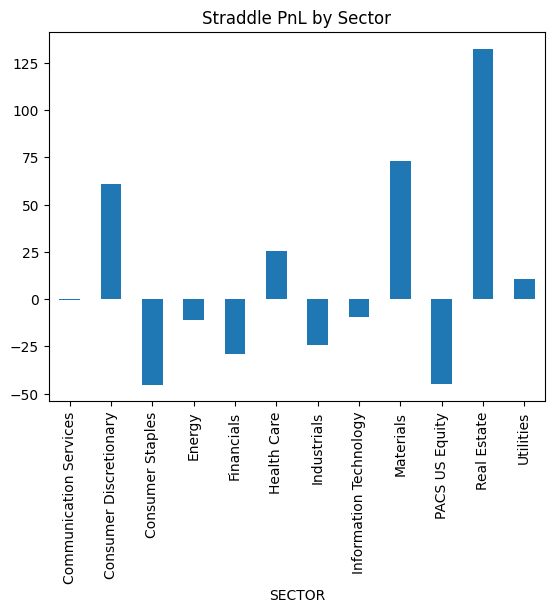

In [30]:
results_by_sector['straddle_pnl'].mean().plot(kind='bar', title='Straddle PnL by Sector')

In [31]:
results_by_sector_year = strategy_sectors.groupby(['SECTOR', 'year_entry'])
results_by_sector_year['straddle_pnl'].mean()

SECTOR                  year_entry
Communication Services  2018          -39.943443
                        2019            2.019178
                        2020           47.620181
                        2021          -40.359509
                        2022           47.513572
                                         ...    
Utilities               2020           -3.555469
                        2021          390.151515
                        2022         -166.788063
                        2023          162.580031
                        2024                 NaN
Name: straddle_pnl, Length: 84, dtype: float64

In [35]:
df = results_by_sector_year.reset_index()
pivot_df = df.pivot(index='year_entry', columns='SECTOR', values='straddle_pnl')
pivot_df.reset_index(inplace=True)
pivot_df.fillna(0, inplace=True)
pivot_df.index = pivot_df['year_entry']
pivot_df


AttributeError: 'DataFrameGroupBy' object has no attribute 'reset_index'

In [33]:
for column in pivot_df.columns:
    if column != 'year_entry':
        plt.scatter(pivot_df.index, pivot_df[column], label=column)

plt.title('Straddle PnL by Sector and Year')
plt.ylabel('Straddle PnL')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

NameError: name 'pivot_df' is not defined

**Sharpe ratio analysis**

In [68]:
def calculate_statistics(df, periods_per_year=252):
    """
    Calculate annualized Sharpe ratios and correlation matrix for a given DataFrame.

    Parameters:
    df (DataFrame): A DataFrame with 'Date' as index, tickers as columns, and returns as values.
    periods_per_year (int): Number of periods per year (default 252 for daily data).

    Returns:
    Tuple[DataFrame, DataFrame]: A tuple containing the DataFrame of Sharpe ratios and the correlation matrix.
    """
    # Calculate mean returns and standard deviation of returns
    mean_returns = df.mean()
    std_dev_returns = df.std()
    
    # Calculate annualized Sharpe Ratio (assuming the risk-free rate is approximately 0)
    sharpe_ratios = mean_returns / std_dev_returns * np.sqrt(periods_per_year)
    
    # Create a DataFrame for Sharpe ratios
    sharpe_df = pd.DataFrame(sharpe_ratios, columns=['Sharpe Ratio'])
    
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    return sharpe_df, correlation_matrix

In [39]:
strategy_sectors['SECTOR'].unique()

array(['Health Care', 'Materials', 'Industrials',
       'Consumer Discretionary', 'Information Technology', 'Financials',
       'Consumer Staples', 'Utilities', 'PACS US Equity',
       'Communication Services', 'Real Estate', 'Energy'], dtype=object)

In [50]:
# Get unique sectors
sectors = strategy_sectors['SECTOR'].unique()

# Loop over sectors and create a DataFrame for each one
for sector in sectors:
    # Replace spaces with underscores in the sector name
    sector_name = sector.replace(' ', '_')
    globals()[f'df_{sector_name}'] = strategy_sectors[strategy_sectors['SECTOR'] == sector]

**Health care**

In [51]:
df_Health_Care.set_index('Date', inplace=True)
df_Health_Care.head(1)

,Unnamed: 0,index,ticker,Name,Ticker,Event Type,Adjusted Trading Date,trade_entry,trade_exit,stock_price_entry,stock_price_exit,year_entry,year_exit,straddle_entry_mid,straddle_exit_mid,straddle_pnl,SECTOR
Date,,,,,,,,,,,,,,,,,
2018-02-14 16:05:00,0,396,A,Agilent Technologies Inc,A US,ER,2018-02-15 00:00:00+00:00,2018-02-14,2018-02-15,69.7,72.02,2018,2018,1.1825,1.04,120.5074,Health Care


In [ ]:
# Pivot the DataFrame to get 'ticker' as columns and 'straddle_pnl' as values
result_health = df_Health_Care.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
display(result_health)

ticker,A,ABBV,ABT,ALGN,AMGN,BAX,BBIO,BDX,BIIB,BMY,...,SRPT,SWAV,SYK,THC,TMO,UNH,VRTX,XRAY,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-23 06:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-24 07:45:00,NaN,NaN,-387.850467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-25 06:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.234114e+02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 06:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 08:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-199.186992
2023-02-15 07:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.629685e-13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-16 16:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,376.602564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
sharpe_health, correlation_health = calculate_statistics(result_health)
display(sharpe_health.T)
sorted_health = sharpe_health.sort_values('Sharpe Ratio', ascending=False)
top_10_health = sorted_health.head(10)
display(top_10_health.T)

ticker,A,ABBV,ABT,ALGN,AMGN,BAX,BBIO,BDX,BIIB,BMY,...,SRPT,SWAV,SYK,THC,TMO,UNH,VRTX,XRAY,ZBH,ZTS
Sharpe Ratio,-0.627955,7.832696,3.538788,-3.318619,0.105648,-8.673485,NaN,-2.098914,0.293741,16.200989,...,6.757445,46.125236,87.149342,3.18852,8.603691,1.167095,5.546148,55.893815,NaN,4.63542


ticker,ELAN,SYK,XRAY,MOH,SWAV,EXAS,BMY,BSX,TMO,ABBV
Sharpe Ratio,527.573692,87.149342,55.893815,49.632085,46.125236,18.89169,16.200989,14.504207,8.603691,7.832696


**Materials**

In [69]:
df_Materials.set_index('Date', inplace=True)
result_Materials = df_Materials.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Materials, correlation_Materials = calculate_statistics(result_Materials)
display(sharpe_Materials.T)
sorted_Materials = sharpe_Materials.sort_values('Sharpe Ratio', ascending=False)
top_10_Materials = sorted_Materials.head(10)
display(top_10_Materials.T)


ticker,AA,ALB,ARCH,BERY,CC,CCK,CE,CF,CLF,CMC,...,NUE,OLN,PPG,RPM,SCCO,SEE,SHW,STLD,VMC,X
Sharpe Ratio,-1.310402,-8.341908,6.39109,6.811466,1.918325,6.415098,6.07109,5.878856,61.979335,27.520889,...,4.086349,1.284945,5.386778,NaN,NaN,NaN,-4.881848,7.530436,-44.719008,5.61473


ticker,CLF,FMC,CMC,STLD,DOW,BERY,CCK,ARCH,CE,CF
Sharpe Ratio,61.979335,32.040157,27.520889,7.530436,7.154582,6.811466,6.415098,6.39109,6.07109,5.878856


**Industrials**

In [70]:
df_Industrials.set_index('Date', inplace=True)
result_Industrials = df_Industrials.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Industrials, correlation_Industrials = calculate_statistics(result_Industrials)
display(sharpe_Industrials.T)
sorted_Industrials = sharpe_Industrials.sort_values('Sharpe Ratio', ascending=False)
top_10_Industrials = sorted_Industrials.head(10)
display(top_10_Industrials.T)

ticker,AAL,ACM,ADP,AIR,AL,ALK,ATKR,AXON,BA,BECN,...,UNP,UPS,URI,VRSK,WAB,WCC,WM,WMS,WSO,XPO
Sharpe Ratio,0.471837,28.981417,0.686195,-2.675304,-29.708996,NaN,-10.693508,NaN,5.155027,18.879242,...,0.305103,-6.418025,0.593443,NaN,-1.467479,24.818598,4.961727,NaN,-0.829069,NaN


ticker,RUN,PAYX,CNM,ACM,WCC,CNXC,BECN,SWK,FAST,CMI
Sharpe Ratio,318.744553,122.293118,44.241221,28.981417,24.818598,21.94983,18.879242,17.388831,15.848565,8.471022


**Consumer Discretionary**

In [71]:
df_Consumer_Discretionary.set_index('Date', inplace=True)
result_Consdf_Consumer_Discretionary = df_Consumer_Discretionary.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Consdf_Consumer_Discretionary, correlation_Consdf_Consumer_Discretionary = calculate_statistics(result_Consdf_Consumer_Discretionary)
display(sharpe_Consdf_Consumer_Discretionary.T)
sorted_Consdf_Consumer_Discretionary = sharpe_Consdf_Consumer_Discretionary.sort_values('Sharpe Ratio', ascending=False)
top_10_Consdf_Consumer_Discretionary = sorted_Consdf_Consumer_Discretionary.head(10)
display(top_10_Consdf_Consumer_Discretionary.T)

ticker,AAP,ABNB,AEO,ANF,ARMK,ASO,AZO,BBWI,BBY,BKNG,...,VFC,VSCO,W,WGO,WHR,WING,WSM,WYNN,YETI,YUM
Sharpe Ratio,4.796853,3.618361,10.487953,-4.932056,19.410415,-9.50672,0.224881,3.402916,4.445297,4.876212,...,3.607921,5.748595,2.615269,9.192787,4.757543,588.617099,6.690951,6.131592,1.445465,3.947784


ticker,WING,ULTA,CROX,LEN,CZR,BOOT,H,ARMK,DRI,POOL
Sharpe Ratio,588.617099,154.187381,128.330309,41.295596,38.643474,29.854812,22.174603,19.410415,17.536065,16.181843


**Information Technology**

In [72]:
df_Information_Technology.set_index('Date', inplace=True)
result_Consdf_Information_Technology = df_Information_Technology.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Consdf_Information_Technology, correlation_Consdf_Information_Technology = calculate_statistics(result_Consdf_Information_Technology)
display(sharpe_Consdf_Information_Technology.T)
sorted_Consdf_Information_Technology = sharpe_Consdf_Information_Technology.sort_values('Sharpe Ratio', ascending=False)
top_10_Consdf_Information_Technology = sorted_Consdf_Information_Technology.head(10)
display(top_10_Consdf_Information_Technology.T)

ticker,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,APP,AVGO,...,TWLO,TXN,U,WDAY,WDC,WOLF,YOU,ZBRA,ZM,ZS
Sharpe Ratio,9.831771,-2.854745,-0.033165,-1.291947,6.381,36.751214,5.835929,-2.223818,NaN,-9.961669,...,-3.495458,-2.068053,-14.73435,2.164679,1.780749,-61.545172,5.302674,16.580255,-0.886495,-4.424087


ticker,PTC,AMAT,SMAR,ZBRA,EPAM,HUBS,INTU,NTNX,AAPL,KEYS
Sharpe Ratio,44.274023,36.751214,19.687611,16.580255,15.353074,12.912562,11.680646,11.454442,9.831771,7.78335


**Financials**

In [73]:
df_Financials.set_index('Date', inplace=True)
result_Consdf_Financials = df_Financials.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Consdf_Financials, correlation_Consdf_Financials = calculate_statistics(result_Consdf_Financials)
display(sharpe_Consdf_Financials.T)
sorted_Consdf_Financials = sharpe_Consdf_Financials.sort_values('Sharpe Ratio', ascending=False)
top_10_Consdf_Financials = sorted_Consdf_Financials.head(10)
display(top_10_Consdf_Financials.T)

ticker,AFRM,AIG,ALLY,APO,AXP,BAC,BK,BLK,BX,C,...,STT,SYF,TFC,TOST,TROW,UPST,USB,V,WAL,WFC
Sharpe Ratio,-4.365797,-1.845633,-2.773237,-6.535358,-7.139865,-3.943274,-5.560304,-6.270539,0.131217,13.75049,...,-3.644994,-4.308468,4.930998,-9.663817,0.328016,-11.673158,-3.393843,2.28738,2.135296,3.069757


ticker,FHN,SPGI,COIN,C,JPM,KEY,SQ,CFG,FDS,MS
Sharpe Ratio,99.841018,23.074489,17.88414,13.75049,13.058263,12.949965,9.89331,9.089135,8.957197,7.716683


**Consumer Staples**

In [74]:
df_Consumer_Staples.set_index('Date', inplace=True)
result_Consdf_Consumer_Staples = df_Consumer_Staples.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Consdf_Consumer_Staples, correlation_Consdf_Consumer_Staples = calculate_statistics(result_Consdf_Consumer_Staples)
display(sharpe_Consdf_Consumer_Staples.T)
sorted_Consdf_Consumer_Staples = sharpe_Consdf_Consumer_Staples.sort_values('Sharpe Ratio', ascending=False)
top_10_Consdf_Consumer_Staples = sorted_Consdf_Consumer_Staples.head(10)
display(top_10_Consdf_Consumer_Staples.T)

ticker,ACI,ADM,BG,BRBR,CAG,CALM,CL,CLX,COST,CPB,...,PG,PM,SMPL,STZ,SYY,TGT,TSN,USFD,WBA,WMT
Sharpe Ratio,-17.835597,3.545265,NaN,-54.691886,-2.880668,NaN,NaN,-4.263475,NaN,1.442972,...,6.840331,-1.084601,NaN,-1.201506,-1.116311,-5.299765,8.723464,2.040589,-7.592161,1.703705


ticker,GO,EL,TSN,GIS,KHC,PG,HLF,ADM,PEP,MDLZ
Sharpe Ratio,18.216112,14.347095,8.723464,7.814667,7.255465,6.840331,5.898702,3.545265,2.860499,2.291237


**Utilities**

In [85]:
df_Utilities.set_index('Date', inplace=True)
result_Utilities = df_Utilities.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Utilities, correlation_Utilities = calculate_statistics(result_Utilities)
display(sharpe_Utilities.T)
sorted_Utilities = sharpe_Utilities.sort_values('Sharpe Ratio', ascending=False)
top_10_Utilities = sorted_Utilities.head(10)
display(top_10_Utilities.T)

ticker,AWK,CEG,DUK,EXC,FE,NRG,PCG,SO
Sharpe Ratio,15.752631,NaN,-1.902254,NaN,NaN,-2.762232,-1.96376,-0.479343


ticker,AWK,SO,DUK,PCG,NRG,CEG,EXC,FE
Sharpe Ratio,15.752631,-0.479343,-1.902254,-1.96376,-2.762232,NaN,NaN,NaN


**PACS US Equity**

In [86]:
#df_PACS_US_Equity.set_index('Date', inplace=True)
result_PACS_US_Equity = df_PACS_US_Equity.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_PACS_US_Equity, correlation_PACS_US_Equity = calculate_statistics(result_PACS_US_Equity)
display(sharpe_PACS_US_Equity.T)
sorted_PACS_US_Equity = sharpe_PACS_US_Equity.sort_values('Sharpe Ratio', ascending=False)
top_10_PACS_US_Equity = sorted_PACS_US_Equity.head(10)
display(top_10_PACS_US_Equity.T)

ticker,AMED,AMN,AXNX,GH,QDEL,TDOC,TNDM
Sharpe Ratio,NaN,-0.94425,NaN,NaN,1.413,1.009184,-0.983494


ticker,QDEL,TDOC,AMN,TNDM,AMED,AXNX,GH
Sharpe Ratio,1.413,1.009184,-0.94425,-0.983494,NaN,NaN,NaN


**Communication Services**

In [88]:
#df_Communication_Services.set_index('Date', inplace=True)
result_Communication_Services = df_Communication_Services.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Communication_Services, correlation_Communication_Services = calculate_statistics(result_Communication_Services)
display(sharpe_Communication_Services.T)
sorted_Communication_Services = sharpe_Communication_Services.sort_values('Sharpe Ratio', ascending=False)
top_10_Communication_Services = sorted_Communication_Services.head(10)
display(top_10_Communication_Services.T)

ticker,AMC,CHTR,CMCSA,CNK,DIS,EA,EDR,FOXA,GOOGL,META,...,ROKU,SNAP,T,TMUS,TRIP,TTD,TTWO,VZ,WMG,ZI
Sharpe Ratio,46.865192,-7.40501,4.737045,NaN,6.70567,3.226572,-2.608332,2.056493,-1.143739,-11.521042,...,1.165483,-4.382349,-5.163497,-5.030069,1.357769,-1.145968,2.321474,12.041708,NaN,NaN


ticker,PARA,AMC,VZ,DIS,CMCSA,MTCH,EA,TTWO,FOXA,TRIP
Sharpe Ratio,72.604732,46.865192,12.041708,6.70567,4.737045,3.57049,3.226572,2.321474,2.056493,1.357769


**Real Estate**

In [89]:
#df_Real_Estate.set_index('Date', inplace=True)
result_Real_Estate = df_Real_Estate.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Real_Estate, correlation_Real_Estate = calculate_statistics(result_Real_Estate)
display(sharpe_Real_Estate.T)
sorted_Real_Estate = sharpe_Real_Estate.sort_values('Sharpe Ratio', ascending=False)
top_10_Real_Estate = sorted_Real_Estate.head(10)
display(top_10_Real_Estate.T)

ticker,AMT,CBRE,CCI,DLR,EQIX,IRM,O,PLD,REXR,SBAC,SLG,SPG,VNO,VTR
Sharpe Ratio,6.156516,NaN,15.072422,3.890242,-7.618903,58.165765,NaN,9.571125,NaN,NaN,2.613805,NaN,-7.555875,5.969514


ticker,IRM,CCI,PLD,AMT,VTR,DLR,SLG,VNO,EQIX,CBRE
Sharpe Ratio,58.165765,15.072422,9.571125,6.156516,5.969514,3.890242,2.613805,-7.555875,-7.618903,NaN


**Energy**

In [91]:
#df_Energy.set_index('Date', inplace=True)
result_Energy = df_Energy.pivot_table(index='Date', columns='ticker', values='straddle_pnl', aggfunc='first')
sharpe_Energy, correlation_Energy = calculate_statistics(result_Energy)
display(sharpe_Energy.T)
sorted_Energy = sharpe_Energy.sort_values('Sharpe Ratio', ascending=False)
top_10_Energy = sorted_Energy.head(10)
display(top_10_Energy.T)

ticker,APA,AR,BKR,BTU,COP,CTRA,DVN,EOG,EQT,FANG,...,OXY,PBF,PSX,PXD,SLB,TALO,TRGP,VLO,WMB,XOM
Sharpe Ratio,-1.083544,60.894507,-1.310946,5.100233,1.993852,3.636893,-1.980775,-3.363742,-3.034464,-11.042869,...,-2.484746,5.694311,-4.987913,6.016877,9.644551,NaN,-5.232445,-1.249856,2.727992,-6.519577


ticker,AR,MRO,SLB,PXD,PBF,BTU,CTRA,HES,WMB,KMI
Sharpe Ratio,60.894507,16.901389,9.644551,6.016877,5.694311,5.100233,3.636893,2.811968,2.727992,2.091558


Now get all the tickers of the top 10 sharpe ratio by sector:

In [100]:
top_10_sharpe = []
top_10_sharpe.append(top_10_health.index.tolist())
top_10_sharpe.append(top_10_Materials.index.tolist())
top_10_sharpe.append(top_10_Industrials.index.tolist())
top_10_sharpe.append(top_10_Consdf_Consumer_Discretionary.index.tolist())
top_10_sharpe.append(top_10_Consdf_Information_Technology.index.tolist())
top_10_sharpe.append(top_10_Consdf_Financials.index.tolist())
top_10_sharpe.append(top_10_Consdf_Consumer_Staples.index.tolist())
top_10_sharpe.append(top_10_Utilities.index.tolist())
top_10_sharpe.append(top_10_PACS_US_Equity.index.tolist())
top_10_sharpe.append(top_10_Communication_Services.index.tolist())
top_10_sharpe.append(top_10_Real_Estate.index.tolist())
top_10_sharpe.append(top_10_Energy.index.tolist())
display(top_10_sharpe)

[['ELAN', 'SYK', 'XRAY', 'MOH', 'SWAV', 'EXAS', 'BMY', 'BSX', 'TMO', 'ABBV'],
 ['CLF', 'FMC', 'CMC', 'STLD', 'DOW', 'BERY', 'CCK', 'ARCH', 'CE', 'CF'],
 ['RUN', 'PAYX', 'CNM', 'ACM', 'WCC', 'CNXC', 'BECN', 'SWK', 'FAST', 'CMI'],
 ['WING', 'ULTA', 'CROX', 'LEN', 'CZR', 'BOOT', 'H', 'ARMK', 'DRI', 'POOL'],
 ['PTC',
  'AMAT',
  'SMAR',
  'ZBRA',
  'EPAM',
  'HUBS',
  'INTU',
  'NTNX',
  'AAPL',
  'KEYS'],
 ['FHN', 'SPGI', 'COIN', 'C', 'JPM', 'KEY', 'SQ', 'CFG', 'FDS', 'MS'],
 ['GO', 'EL', 'TSN', 'GIS', 'KHC', 'PG', 'HLF', 'ADM', 'PEP', 'MDLZ'],
 ['AWK', 'SO', 'DUK', 'PCG', 'NRG', 'CEG', 'EXC', 'FE'],
 ['QDEL', 'TDOC', 'AMN', 'TNDM', 'AMED', 'AXNX', 'GH'],
 ['PARA', 'AMC', 'VZ', 'DIS', 'CMCSA', 'MTCH', 'EA', 'TTWO', 'FOXA', 'TRIP'],
 ['IRM', 'CCI', 'PLD', 'AMT', 'VTR', 'DLR', 'SLG', 'VNO', 'EQIX', 'CBRE'],
 ['AR', 'MRO', 'SLB', 'PXD', 'PBF', 'BTU', 'CTRA', 'HES', 'WMB', 'KMI']]

Now select only those ticker for construct the strategy


In [110]:

top_10_sharpe = ['ELN', 'SNC', 'XYL', 'HON', 'SWA', 'EAS', 'DEN', 'BSK', 'TMO', 'ABV',
                 'LIFN', 'FISN', 'CRAT', 'SMDH', 'DENY', 'BECK', 'ARCH', 'SEC', 'GFI', 'WLN',
                 'RUNC', 'PAYX', 'COM', 'AMD', 'MCC', 'DCC', 'BGEN', 'SIK', 'FAST', 'CHIL',
                 'PWRG', 'ULTA', 'CROX', 'LEN', 'CZR', 'BOOT', 'HP', 'ARMK', 'DRI', 'POOL',
                 'MAT', 'AMR', 'SBRA', 'ZNAT', 'EPAM', 'NUS', 'NBR', 'ANNX', 'NPL', 'AAPL', 
                 'HEI', 'GS', 'CST', 'CON', 'CP', 'KEY', 'SQ', 'CGC', 'FPS', 'NS', 
                 'FON', 'SPL', 'IGL', 'IS', 'XCT', 'PG', 'HFL', 'ADN', 'PED', 'HOLZ', 
                 'OAK', 'SO', 'DOCK', 'PETS', 'NMG', 'LEC', 'KXC', 'FF', 'PME', 'TRUCK', 
                 'AVG', 'DINC', 'CAGED', 'EXON', 'GEL', 'LOAD', 'SDA', 'ADV', 'DDS', 'NSA', 
                 'TECH', 'TEA', 'MWC', 'PEPS', 'NECA', 'HYTECH', 'TIVO', 'FOXA', 'TRIP', 
                 'IR', 'CCI', 'PLD', 'AMT', 'VTR', 'DRI', 'SLG', 'VNO', 'EQIX', 'CBRE', 
                 'AAR', 'NCO', 'SLED', 'PPD', 'FSB', 'UTA', 'CRS', 'HES', 'WMB', 'KMI']

filtered_df = earnings_dates_for_tickers[earnings_dates_for_tickers['ticker'].isin(top_10_sharpe)]
filtered_df


,Unnamed: 0,index,ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,trade_entry,trade_exit,stock_price_entry,stock_price_exit,year_entry,year_exit,straddle_entry_mid,straddle_exit_mid,straddle_pnl
103,103,230,AAPL,Apple Inc,AAPL US,2018-02-01 16:30:00,ER,2018-02-02 00:00:00+00:00,2018-02-01,2018-02-02,167.78000,160.50000,2018,2018,3.4625,NaN,NaN
104,104,1040,AAPL,Apple Inc,AAPL US,2018-05-01 16:30:00,ER,2018-05-02 00:00:00+00:00,2018-05-01,2018-05-02,169.10001,176.57001,2018,2018,3.8250,3.4725,92.156863
105,105,1732,AAPL,Apple Inc,AAPL US,2018-07-31 16:30:00,ER,2018-08-01 00:00:00+00:00,2018-07-31,2018-08-01,190.28999,201.50000,2018,2018,4.5125,5.8900,-305.263158
106,106,2541,AAPL,Apple Inc,AAPL US,2018-11-01 16:30:00,ER,2018-11-02 00:00:00+00:00,2018-11-01,2018-11-02,222.22000,207.48000,2018,2018,5.6125,NaN,NaN
107,107,2975,AAPL,Apple Inc,AAPL US,2019-01-29 16:30:00,ER,2019-01-30 00:00:00+00:00,2019-01-29,2019-01-30,154.67999,165.25000,2019,2019,4.3750,5.3150,-214.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19247,19247,15845,XYL,Xylem Inc/NY,XYL US,2023-02-07 06:55:00,ER,2023-02-06 00:00:00+00:00,2023-02-06,2023-02-07,104.05000,107.77000,2023,2023,NaN,NaN,NaN
19248,19248,16898,XYL,Xylem Inc/NY,XYL US,2023-05-04 06:55:00,ER,2023-05-03 00:00:00+00:00,2023-05-03,2023-05-04,104.15000,106.33000,2023,2023,NaN,NaN,NaN
19249,19249,17687,XYL,Xylem Inc/NY,XYL US,2023-08-02 06:55:00,ER,2023-08-01 00:00:00+00:00,2023-08-01,2023-08-02,111.93000,112.08000,2023,2023,NaN,NaN,NaN
19250,19250,18497,XYL,Xylem Inc/NY,XYL US,2023-10-31 06:55:00,ER,2023-10-30 00:00:00+00:00,2023-10-30,2023-10-31,89.27000,93.54000,2023,2023,NaN,NaN,NaN


In [111]:
filtered_df['straddle_pnl'].mean()

137.1449886260343

In [112]:
filtered_df.groupby('year_entry')['straddle_pnl'].mean()

year_entry
2018    137.213318
2019     26.320279
2020    171.470180
2021    280.836307
2022    160.582367
2023    153.595745
2024           NaN
Name: straddle_pnl, dtype: float64

In [113]:
earnings_dates_for_tickers.groupby('year_entry')['straddle_pnl'].mean()

year_entry
2018   -23.132445
2019   -28.775050
2020    32.089584
2021     9.297937
2022    34.475380
2023    -7.015307
2024          NaN
Name: straddle_pnl, dtype: float64